In [1]:
from timm.models.vision_transformer import VisionTransformer
from torchvision.io import read_image
from torchvision import transforms
import torch.nn.functional as F
from torch.fx import symbolic_trace
from torch.autograd import Function
import requests
from PIL import Image
from io import BytesIO
import torch
import timm
import json
import urllib.request
import matplotlib.pyplot as plt

c:\Users\ASUS\miniconda3\envs\xformers-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").splitlines()
model = timm.create_model('vit_base_patch16_224', pretrained=True)
m = model.eval()

In [3]:
# Download a sample image
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])
x = transform(image).unsqueeze(0)

In [25]:
with torch.no_grad():
    y = model(x)

In [24]:
activations = []
def forward_hook(module,input,output):
    activations.append(input)
handle = model.head.register_forward_hook(forward_hook)

In [99]:
@torch.no_grad
def linear_lrp(R_out, module, output, activation, eps=1e-8, **kwargs):
    W = module.weight
    S = R_out/(output + eps)
    numen = activation[:,:,None] * W.T[None,:,:]
    R_in = numen*S[:,None,:]
    return R_in.sum(-1)
@torch.no_grad
def identity_lrp(R_out, **kwargs):
    return R_out

In [28]:
activations[0][0].shape

torch.Size([1, 768])

In [31]:
R = torch.zeros_like(y)
R[0,torch.argmax(y)] = y[0,torch.argmax(y)]

In [91]:
R_ = linear_lrp(R,model.head,y,activations[0][0])

In [92]:
P = R_.squeeze(0).detach().numpy()

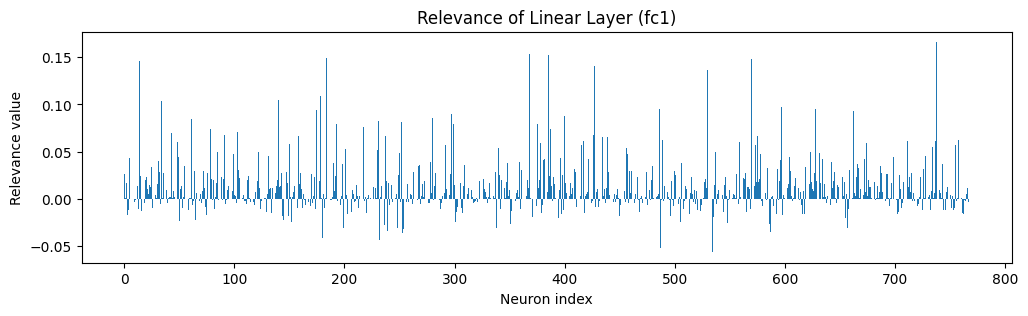

In [96]:
plt.figure(figsize=(12, 3))
plt.bar(range(len(P)), P)
plt.title("Relevance of Linear Layer (fc1)")
plt.xlabel("Neuron index")
plt.ylabel("Relevance value")
plt.show()

In [11]:
for name, module in model.named_modules():
    print(name, type(module))

 <class 'timm.models.vision_transformer.VisionTransformer'>
patch_embed <class 'timm.layers.patch_embed.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
patch_embed.norm <class 'torch.nn.modules.linear.Identity'>
pos_drop <class 'torch.nn.modules.dropout.Dropout'>
patch_drop <class 'torch.nn.modules.linear.Identity'>
norm_pre <class 'torch.nn.modules.linear.Identity'>
blocks <class 'torch.nn.modules.container.Sequential'>
blocks.0 <class 'timm.models.vision_transformer.Block'>
blocks.0.norm1 <class 'timm.layers.norm.LayerNorm'>
blocks.0.attn <class 'timm.layers.attention.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.q_norm <class 'torch.nn.modules.linear.Identity'>
blocks.0.attn.k_norm <class 'torch.nn.modules.linear.Identity'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.norm <class 'torch.nn.modules.linear.Identity'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.

In [12]:
class epsilon_lrp_fn(Function):
    @staticmethod
    def forward(ctx, fn, epsilon, *inputs):

        # create boolean mask for inputs requiring gradients
        #TODO: use ctx.needs_input_grad instead of requires_grad
        requires_grads = [True if inp.requires_grad else False for inp in inputs]
        if sum(requires_grads) == 0:
            # no gradients to compute or gradient checkpointing is used
            return fn(*inputs)
        
        # detach inputs to avoid overwriting gradients if same input is used as multiple arguments (like in self-attention)
        inputs = tuple(inp.detach().requires_grad_() if inp.requires_grad else inp for inp in inputs)

        with torch.enable_grad():
            outputs = fn(*inputs)

        ctx.epsilon, ctx.requires_grads = epsilon, requires_grads
        # save only inputs requiring gradients
        inputs = tuple(inputs[i] for i in range(len(inputs)) if requires_grads[i])
        ctx.save_for_backward(*inputs, outputs)
        
        return outputs.detach()
        
    @staticmethod
    def backward(ctx, *out_relevance):

        inputs, outputs = ctx.saved_tensors[:-1], ctx.saved_tensors[-1]
        relevance_norm = out_relevance[0] / _stabilize(outputs, ctx.epsilon, inplace=False)

        # computes vector-jacobian product
        grads = torch.autograd.grad(outputs, inputs, relevance_norm)

        # return relevance at requires_grad indices else None
        relevance = iter([grads[i].mul_(inputs[i]) for i in range(len(inputs))])
        return (None, None) + tuple(next(relevance) if req_grad else None for req_grad in ctx.requires_grads)
class identity_fn(Function):

    @staticmethod
    def forward(ctx, fn, input):

        output = fn(input)
        return output

    @staticmethod
    def backward(ctx, *out_relevance):
        return (None,) + out_relevance

class softmax_fn(Function):

    @staticmethod
    def forward(cache, inputs, dim, temprature=1.0, dtype=None, inplace=False):
        if dtype is not None:
            inputs = inputs.to(dtype)
        inputs = inputs/temprature
        outputs = F.softmax(inputs, dim=dim, dtype=dtype)

        cache.save_for_backward(inputs, outputs)
        cache.inplace=inplace
        return outputs
    @staticmethod
    def backward(cache, *R_out):
        inputs, outputs = cache.saved_tensors
        R_out = R_out[0]
        inputs = torch.where(torch.isneginf(inputs),torch.tensor(0).to(inputs), inputs)
        if cache.inplace:
            R_in = (R_out.sub_(outputs.mul_(R_out.sum(-1, keepdim=True)))).mul_(inputs)
        else:
            R_in = inputs * (R_out - outputs * R_out.sum(-1, keepdim=True))
        return (R_in, None, None, None, None)

class linear_fn(Function):

    @staticmethod
    def forward(cache, inputs, weight, bias, epsilon=1e-8):
        outputs = F.linear(inputs, weight, bias)
        cache.save_for_backward(inputs, outputs, weight)
        cache.epsilon = epsilon
        return outputs
    @staticmethod
    def backward(cache, *R_out):
        inputs, outputs, weight = cache.saved_tensors
        R_out = R_out[0]
        S = R_out/outputs.add_(cache.epsilon)
        R_in = torch.matmul(S, weight).mul_(inputs)
        return (R_in, None, None, None)

class matmul_fn(Function):
    '''This is LRP bkwd for Attn matmul between A (softmax(Q.(K.T)/sqrt(dim))) and V (value vector), don't confuse with linear ops between input and weight matrix'''

    @staticmethod
    def forward(cache, input_a, input_b, epsilon=1e-12, inplace=False):
        output = torch.matmul(input_a, input_b)
        cache.save_for_backward(input_a, input_b, output)
        cache.epsilon=epsilon
        cache.inplace = inplace
        return output

    @staticmethod
    def backward(cache, *R_out):
        R_out = R_out[0]
        input_a, input_b, output = cache.saved_tensors
        epsilon, inplace = cache.epsilon, cache.inplace
        if inplace:
            S = R_out.div_(output.mul_(2).add_(epsilon))
        else:
            S = R_out / ((2*output)+epsilon)
        R_ina = torch.matmul(S, input_b.T).mul_(input_a)
        R_inb = torch.matmul(input_a.T, S).mul_(inbut_b)
        return (R_ina, R_inb, None, None)

class add_2_tensors_fn(Function):

    @staticmethod
    def forward(cache, input_a, input_b, inplace=False, epsilon=1e-8):
        outputs = input_a + input_b
        cache.requires_grads = [i for i, inp in enumerate((input_a, input_b)) if isinstance(inp, torch.Tensor) and inp.requires_grad]
        if input_a.requires_grad or input_b.requires_grad:
            cache.save_for_backward(input_a, input_b)
            cache.inplace=inplace
            cache.epsilon = epsilon
        return outputs

    @staticmethod
    def backward(cache, *R_out):
        if not cache.requires_grads:
            return (None, None, None, None)
        input_a, input_b = cache.saved_tensors
        R_out = R_out[0]
        epsilon = cache.epsilon
        if cache.inplace:
            R_ina = (R_out * input_a).div_(input_a+input_b+epsilon)
            R_inb = R_out.mul_(input_b).div_(input_a+input_b+epsilon)
        else:
            R_ina = (R_out * input_a).div_(input_a+input_b+epsilon)
            R_inb = (R_out * input_b).div_(input_a+input_b+epsilon)
        return (R_ina if 0 in cache.requires_grads else None, R_inb if 1 in cache.requires_grads else None, None, None)

class mul2_fn(Function):

    @staticmethod
    def forward(cache, input_a, input_b, inplace=False):

        cache.requires_grads = [i for i, inp in enumerate((input_a, input_b)) if isinstance(inp, torch.Tensor) and inp.requires_grad]
        cache.inplace = inplace

        return input_a * input_b

    @staticmethod
    def backward(cache, *R_out):

        n = len(cache.requires_grads)
        R_out = R_out[0]
        if cache.inplace:
            R_in = R_out.div_(n)
        else:
            R_in = R_out / n
        return tuple(R_in if i in ctx.requires_grads else None for i in range(2)) + (None,)

class layernorm_fn(Function):

    @staticmethod
    def forward(cache, input, weight, bias, epsilon=1e-6, var_epsilon=1e-6):
        
        with torch.enable_grad():

            mean = input.mean(-1, keepdim=True)
            var = ((input - mean)**2).mean(-1, keepdim=True)
            std = (var + var_epsilon).sqrt()
            y = (input-mean)/std.detach()
            y = y * weight + bias

            cache.save_for_backward(input, y)
            cache.epsilon = epsilon
        
        return y.detach()
    
    @staticmethod
    def backward(cache, *R_out):
        x, y = cache.saved_tensors

        R_out = R_out[0]
        R_norm = R_out/ (y + cache.epsilon)
        grads = torch.autograd.grad(y, x, R_norm)
        R_in = grads*x
        return (R_in, None, None, None, None)

class conv_fn(Function):

    @staticmethod
    def forward(cache, inputs, module,lowest=0., highest=1.):
        output = module(inputs)
        cache.stride, cache.padding, cache.kernel, cache.lowest, cache.highest = module.stride, module.padding, module.kernel_size, lowest, highest
        cache.save_for_backward(inputs, output, module.weight)
        return output

    @staticmethod
    def backward(cache, *R_out):
        R = R_out[0]
        stride, padding, kernel, lowest, highest = cache.stride, cache.padding, cache.kernel, cache.lowest, cache.highest
        activation, Z_O, weight = cache.saved_tensors
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] \
                                                - 2 * padding[0] + kernel[0])
        W_L = torch.clamp(weight, min=0)
        W_H = torch.clamp(weight, max=0)

        L = torch.ones_like(activation, dtype=activation.dtype) * lowest
        H = torch.ones_like(activation, dtype=activation.dtype) * highest
        Z_L = F.conv2d(L, W_L, stride=stride, padding=padding)
        Z_H = F.conv2d(H, W_H, stride=stride, padding=padding)
        Z = Z_O - Z_L - Z_H + 1e-9
        S = R / Z

        C_O = F.conv_transpose2d(S, module.weight, stride=stride, padding=padding, output_padding=output_padding)
        C_L = F.conv_transpose2d(S, W_L, stride=stride, padding=padding, output_padding=output_padding)
        C_H = F.conv_transpose2d(S, W_H, stride=stride, padding=padding, output_padding=output_padding)

        R_in = activation * C_O - L * C_L - H * C_H

        return (R_in, None, None, None)

In [13]:
@torch.fx.wrap
def softmax(inputs, dim, temprature=1.0, dtype=None, inplace=False):
    return softmax_fn.apply(inputs, dim, temprature=1.0, dtype=None, inplace=False)

@torch.fx.wrap
def linear(module, inputs, epsilon=1e-8):
    return linear_fn.apply(inputs, module.weight, module.bias, epsilon)

@torch.fx.wrap
def matmul(input_a, input_b, epsilon=1e-12, inplace=False):
    return matmul_fn.apply(input_a, input_b, epsilon=1e-12, inplace=False)

@torch.fx.wrap
def add(input_a, input_b, inplace=False, epsilon=1e-8):
    return matmul_fn.apply(input_a, input_b, inplace=False, epsilon=1e-8)

@torch.fx.wrap
def mul(input_a, input_b, inplace=False):
    return mul2_fn.apply(input_a, input_b, inplace=False)

@torch.fx.wrap
def layernorm(module, input, epsilon=1e-6, var_epsilon=1e-6):
    return layernorm_fn.apply(input, module.weight, module.bias, epsilon=1e-6, var_epsilon=1e-6)

@torch.fx.wrap
def identity(fn, input):
    return identity_fn.apply(fn, input)

@torch.fx.wrap
def epsilon_lrp(fn, epsilon, *inputs):
    return epsilon_lrp_fn.apply(fn, epsilon, *inputs)

@torch.fx.wrap
def conv_2d(fn, inputs):
    return conv_fn.apply(inputs,fn)

@torch.fx.wrap
def multihead_attn_fn_cp(dim: int,
        x,
        qkv,
        q_norm,
        k_norm,
        attn_drop,
        norm,
        proj,
        proj_drop,
        num_heads: int = 8,
        attn_mask=None):

        assert dim%num_heads==0, 'dim should be divisible by num_heads'
        if qk_norm or scale_norm:
            assert norm_layer is not None, 'norm_layer must be provided if qk_norm or scale_norm is True'
        head_dim = dim//num_heads
        scale = head_dim ** -0.5
        B, N, C = x.shape
        qkv_ = qkv(x).reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv_.unbind(0)
        q, k = q_norm(q), k_norm(k)
        q = q * scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + attn_mask if attn_mask is not None else attn
        attn = attn.softmax(-1)
        attn = attn_drop(attn)
        x = epsilon_lrp(torch.matmul, 1e-6, attention.detach(), v)
        x = x.transpose(1, 2).reshape(B,N,C)
        x = norm(x)
        x = proj(x)
        x = proj_drop(x)
        return x